# Quantum Approximate Optimization Algorithm (QAOA)
________________________

This demo code reproduces the QAOA for MaxCut problem example from [Qiskit](https://qiskit.org/textbook/ch-applications/qaoa.html) and [Pennylane](https://pennylane.ai/qml/demos/tutorial_qaoa_maxcut.html) tutorials. 

Here I only present the explicit Tequila code. Check the above tutorials for details about the problem and theory.

In [1]:
# Import everything we need
import tequila as tq
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Some useful functions

# Exact ground state from a general Hamiltonian
def exact(ham):
    ham_matrix = ham.to_matrix()
    energ = np.linalg.eigvals(ham_matrix)
    return(min(energ))

# Exact eigenstates and eigenvalues of a general Hamiltonian
def exact_state(ham):
    ham_matrix = ham.to_matrix()
    eigenValues, eigenVectors = np.linalg.eig(ham_matrix)
    idx = eigenValues.argsort()[::-1]   
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return(eigenValues,eigenVectors)

In [3]:
# Problem Hamiltonian
def HP(param,graph):
    """
    param (list): Problem Hamiltonian parameters
    graph (2D list): Hamiltonian connectivity
    """
    ham = tq.QubitHamiltonian() 
    for k in range(len(graph)):
        ham -= param[k]*0.5*(1-tq.paulis.Z(graph[k][0])*tq.paulis.Z(graph[k][1]))
    return(ham)

# commuting part (Pauli string) from the problem Hamiltonian
def HP_str(q1,q2):
    ham_prob = "Z({})Z({})".format(q1,q2)
    return ham_prob

# commuting part (Pauli string) from the mixing Hamiltonian
def HM_str(q1):
    ham_mix = "X({})".format(q1)
    return ham_mix

In [4]:
def QAOA_circuit(qubits,layers,graph):
    
    circuit = tq.QCircuit()
    
    #init state (eigenstate from the mixing Hamiltonian, |+>^n state for this example)
    circuit += tq.gates.H(range(qubits))
    
    for l in range(layers):
        beta = tq.Variable(name="beta{}".format(l))
        gamma = tq.Variable(name="gamma{}".format(l)) 
        for k in range(qubits):
            circuit += tq.gates.ExpPauli(angle=beta, paulistring=HM_str(k))
        for k in range(len(graph)):
            circuit += tq.gates.ExpPauli(angle=gamma, paulistring=HP_str(graph[k][0],graph[k][1]))
    
    return circuit

# VQE hardware-efficient: layer= single-qubit Ry gates + alternating CNOTs
# for comparison with QAOA
def VQE_HE(qubits,layers):
    
    circuit = tq.QCircuit()
    
    for l in range(layers):
        for i in range(qubits-1):
            th = tq.Variable(name="th{}{}".format(i,l))
            circuit += tq.gates.Ry(target=i, angle=th)
        # Layer alternating CNOTs
        ent0 = np.mod(l, 2)
        for ent in range(ent0, qubits - 1, 2):
            circuit += tq.gates.CNOT(control=ent, target=ent + 1)
    
    return circuit


In [8]:
qubits = 4 # number of qubits

# To check the results as we consider more layers (variational parameters)
lay_max_VQE = 3 # number of maximal layers for VQE hardware efficient ansatz
lay_max_QAOA = 2*lay_max_VQE # number of maximal layers for QAOA ansatz

# Optimizer options
methods = 'COBYLA'
grad_methods = '2-point'
backend = 'qulacs'
lr = 0.01
# make sure scipy version is >= 1.5
mthd_opt = {'finite_diff_rel_step': 0.0001}

# MAX-CUT problem example
graph = [[0, 1], [0, 3], [1, 2], [2, 3]]
# assuming random parameters
#param = [random.uniform(0,1) for i in range(len(graph))]
# assuming param=1 (original Max-cut example)
param = [1 for i in range(len(graph))]

print("parameters = ", param)
print("graph: ", graph)
print("exact energy = ", exact(HP(param,graph)))
#print("exact states = ", exact_state(HP(qubits,param,graph)))

energ_QAOA = []
energ_VQE = []
param_QAOA=[]
param_VQE=[]

for layers in range(1,lay_max_QAOA+1):
    
    # Objective function
    Obj_QAOA = tq.ExpectationValue(H=HP(param,graph), U=QAOA_circuit(qubits,layers,graph))
    var_QAOA = Obj_QAOA.extract_variables() # how many variational parameters contain
    
    # Random initialization of variables
    var0 = {key: random.uniform(0, np.pi) for key in var_QAOA}
    initial_values = var0
    
    # classical optimization
    QAOA = tq.minimize(objective=Obj_QAOA, adaptive = True, lr=lr, method_options=mthd_opt, method=methods, gradient=grad_methods, samples=None,
                          initial_values=initial_values, backend=backend, noise=None, device=None, silent=True)      
    
    energ_QAOA.append(QAOA.energy) # energy solution
    # QA0A.angles # solution (variational parameters)
    param_QAOA.append(len(var_QAOA))
    
    print(f"QAOA) {layers} layers ({len(var_QAOA)} parameters): {QAOA.energy}")

# Simulate wavefunction final number of layers 
wfn = tq.simulate(QAOA_circuit(qubits,layers,graph), samples=100, variables=QAOA.angles, backend=backend)
print(wfn)


# Hardware-efficient VQE

for layers in range(1,lay_max_VQE+1):
    
    Obj_VQE = tq.ExpectationValue(H=HP(param,graph), U=VQE_HE(qubits,layers))
    var_VQE = Obj_VQE.extract_variables()
    
    # Random initialization of variables
    var0 = {key: random.uniform(0, np.pi) for key in var_VQE}
    initial_values = var0
    
    VQE = tq.minimize(objective=Obj_VQE, adaptive = True, lr=lr, method_options=mthd_opt, method=methods, gradient=grad_methods, samples=None,
                          initial_values=initial_values, backend=backend, noise=None, device=None, silent=True)      
    
    energ_VQE.append(VQE.energy)
    param_VQE.append(len(var_VQE))
    
    print(f"VQE) {layers} layers ({len(var_VQE)} parameters): {VQE.energy}")
    
wfn = tq.simulate(VQE_HE(qubits,layers), samples=100, variables=VQE.angles, backend=backend)
print(wfn)

parameters =  [1, 1, 1, 1]
graph:  [[0, 1], [0, 3], [1, 2], [2, 3]]
exact energy =  (-4+0j)
QAOA) 1 layers (2 parameters): -2.0
QAOA) 2 layers (4 parameters): -2.999999635412692
QAOA) 3 layers (6 parameters): -3.9999990931931464
QAOA) 4 layers (8 parameters): -3.9999994309843405
QAOA) 5 layers (10 parameters): -3.9999378551577838
QAOA) 6 layers (12 parameters): -3.9999883750793974
+51.0000|1010> +49.0000|0101> 
VQE) 1 layers (3 parameters): -1.999999992820456
VQE) 2 layers (6 parameters): -3.999999646750707
VQE) 3 layers (9 parameters): -3.9990771404706233
+100.0000|0101> 


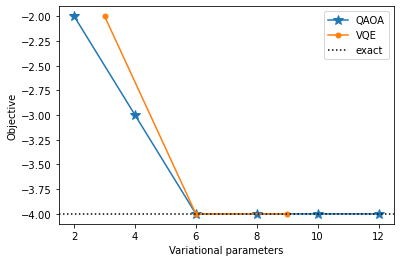

In [9]:
# Plot the results
plt.plot(param_QAOA,energ_QAOA, marker="*", markersize=10,label="QAOA")
plt.plot(param_VQE,energ_VQE,marker=".",markersize=10,label="VQE")
plt.axhline(exact(HP(param,graph)), color="black", linestyle=":", label="exact")
plt.xlabel("Variational parameters")
plt.ylabel("Objective")
plt.legend()
plt.show()

## Some questions and suggestions

- VQE vs QAOA not clear which one is better (this is a very simple example). Explore the advantages of QAOA (precision of the results, number of variational parameters, circuit depth, etc).
- Almost all QAOA tutorials use the "square" MAX-CUT problem. Other problems where combinatorial optimization is required? (e.g. Travelling Salesman Problem)
- Write a beautiful Tequila tutorial about QAOA, upload it to the [Tequila tutorials Github](https://github.com/aspuru-guzik-group/tequila-tutorials) and become a Tequila contributor!